In [1]:
#모델 학습
import tensorflow as tf

from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.applications import inception_v3
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input as inception_v3_preprocessor

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img

from tensorflow.keras.callbacks import Callback
from sklearn.metrics import (f1_score, precision_score, recall_score)

from collections import Counter
import itertools
import numpy as np 
import pandas as pd

from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

#train, test 분류
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score

#날짜 생성
from datetime import datetime

#그래프 생성
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
class Metrics(Callback):
    def __init__(self, validation_generator, validation_steps=None, threshold=0.5):
        self.validation_generator = validation_generator
        self.validation_steps = validation_steps or len(validation_generator)
        self.threshold = threshold

    def on_train_begin(self, logs={}):
        self.val_f1_scores = []
        self.val_recalls = []
        self.val_precisions = []

    def on_epoch_end(self, epoch, logs={}):
        gen_1, gen_2 = itertools.tee(self.validation_generator)
        y_true = np.vstack(next(gen_1)[1] for _ in range(self.validation_steps)).astype('int')
        y_pred = (self.model.predict_generator(gen_2, steps=self.validation_steps) > self.threshold).astype('int')
        _val_f1 = f1_score(y_true, y_pred, average='weighted')
        _val_recall = recall_score(y_true, y_pred, average='weighted')
        _val_precision = precision_score(y_true, y_pred, average='weighted')
        self.val_f1_scores.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)
        print(f" - val_f1_score: {_val_f1:.5f} - val_precision: {_val_precision:.5f} - val_recall: {_val_recall:.5f}")
        return

In [3]:
train_folder = 'C:\\Users\\BVer\\dog_\\YJ_Kim\\dataset\\images1111111111ori'
train_dogs = pd.read_csv('C:\\Users\\BVer\\dog_\\YJ_Kim\\dataset\\data_ori.csv')
train_dogs.head()

,path,label
0,C:\Users\BVer\dog_\YJ_Kim\dataset\images111111...,affenpinscher
1,C:\Users\BVer\dog_\YJ_Kim\dataset\images111111...,affenpinscher
2,C:\Users\BVer\dog_\YJ_Kim\dataset\images111111...,affenpinscher
3,C:\Users\BVer\dog_\YJ_Kim\dataset\images111111...,affenpinscher
4,C:\Users\BVer\dog_\YJ_Kim\dataset\images111111...,affenpinscher


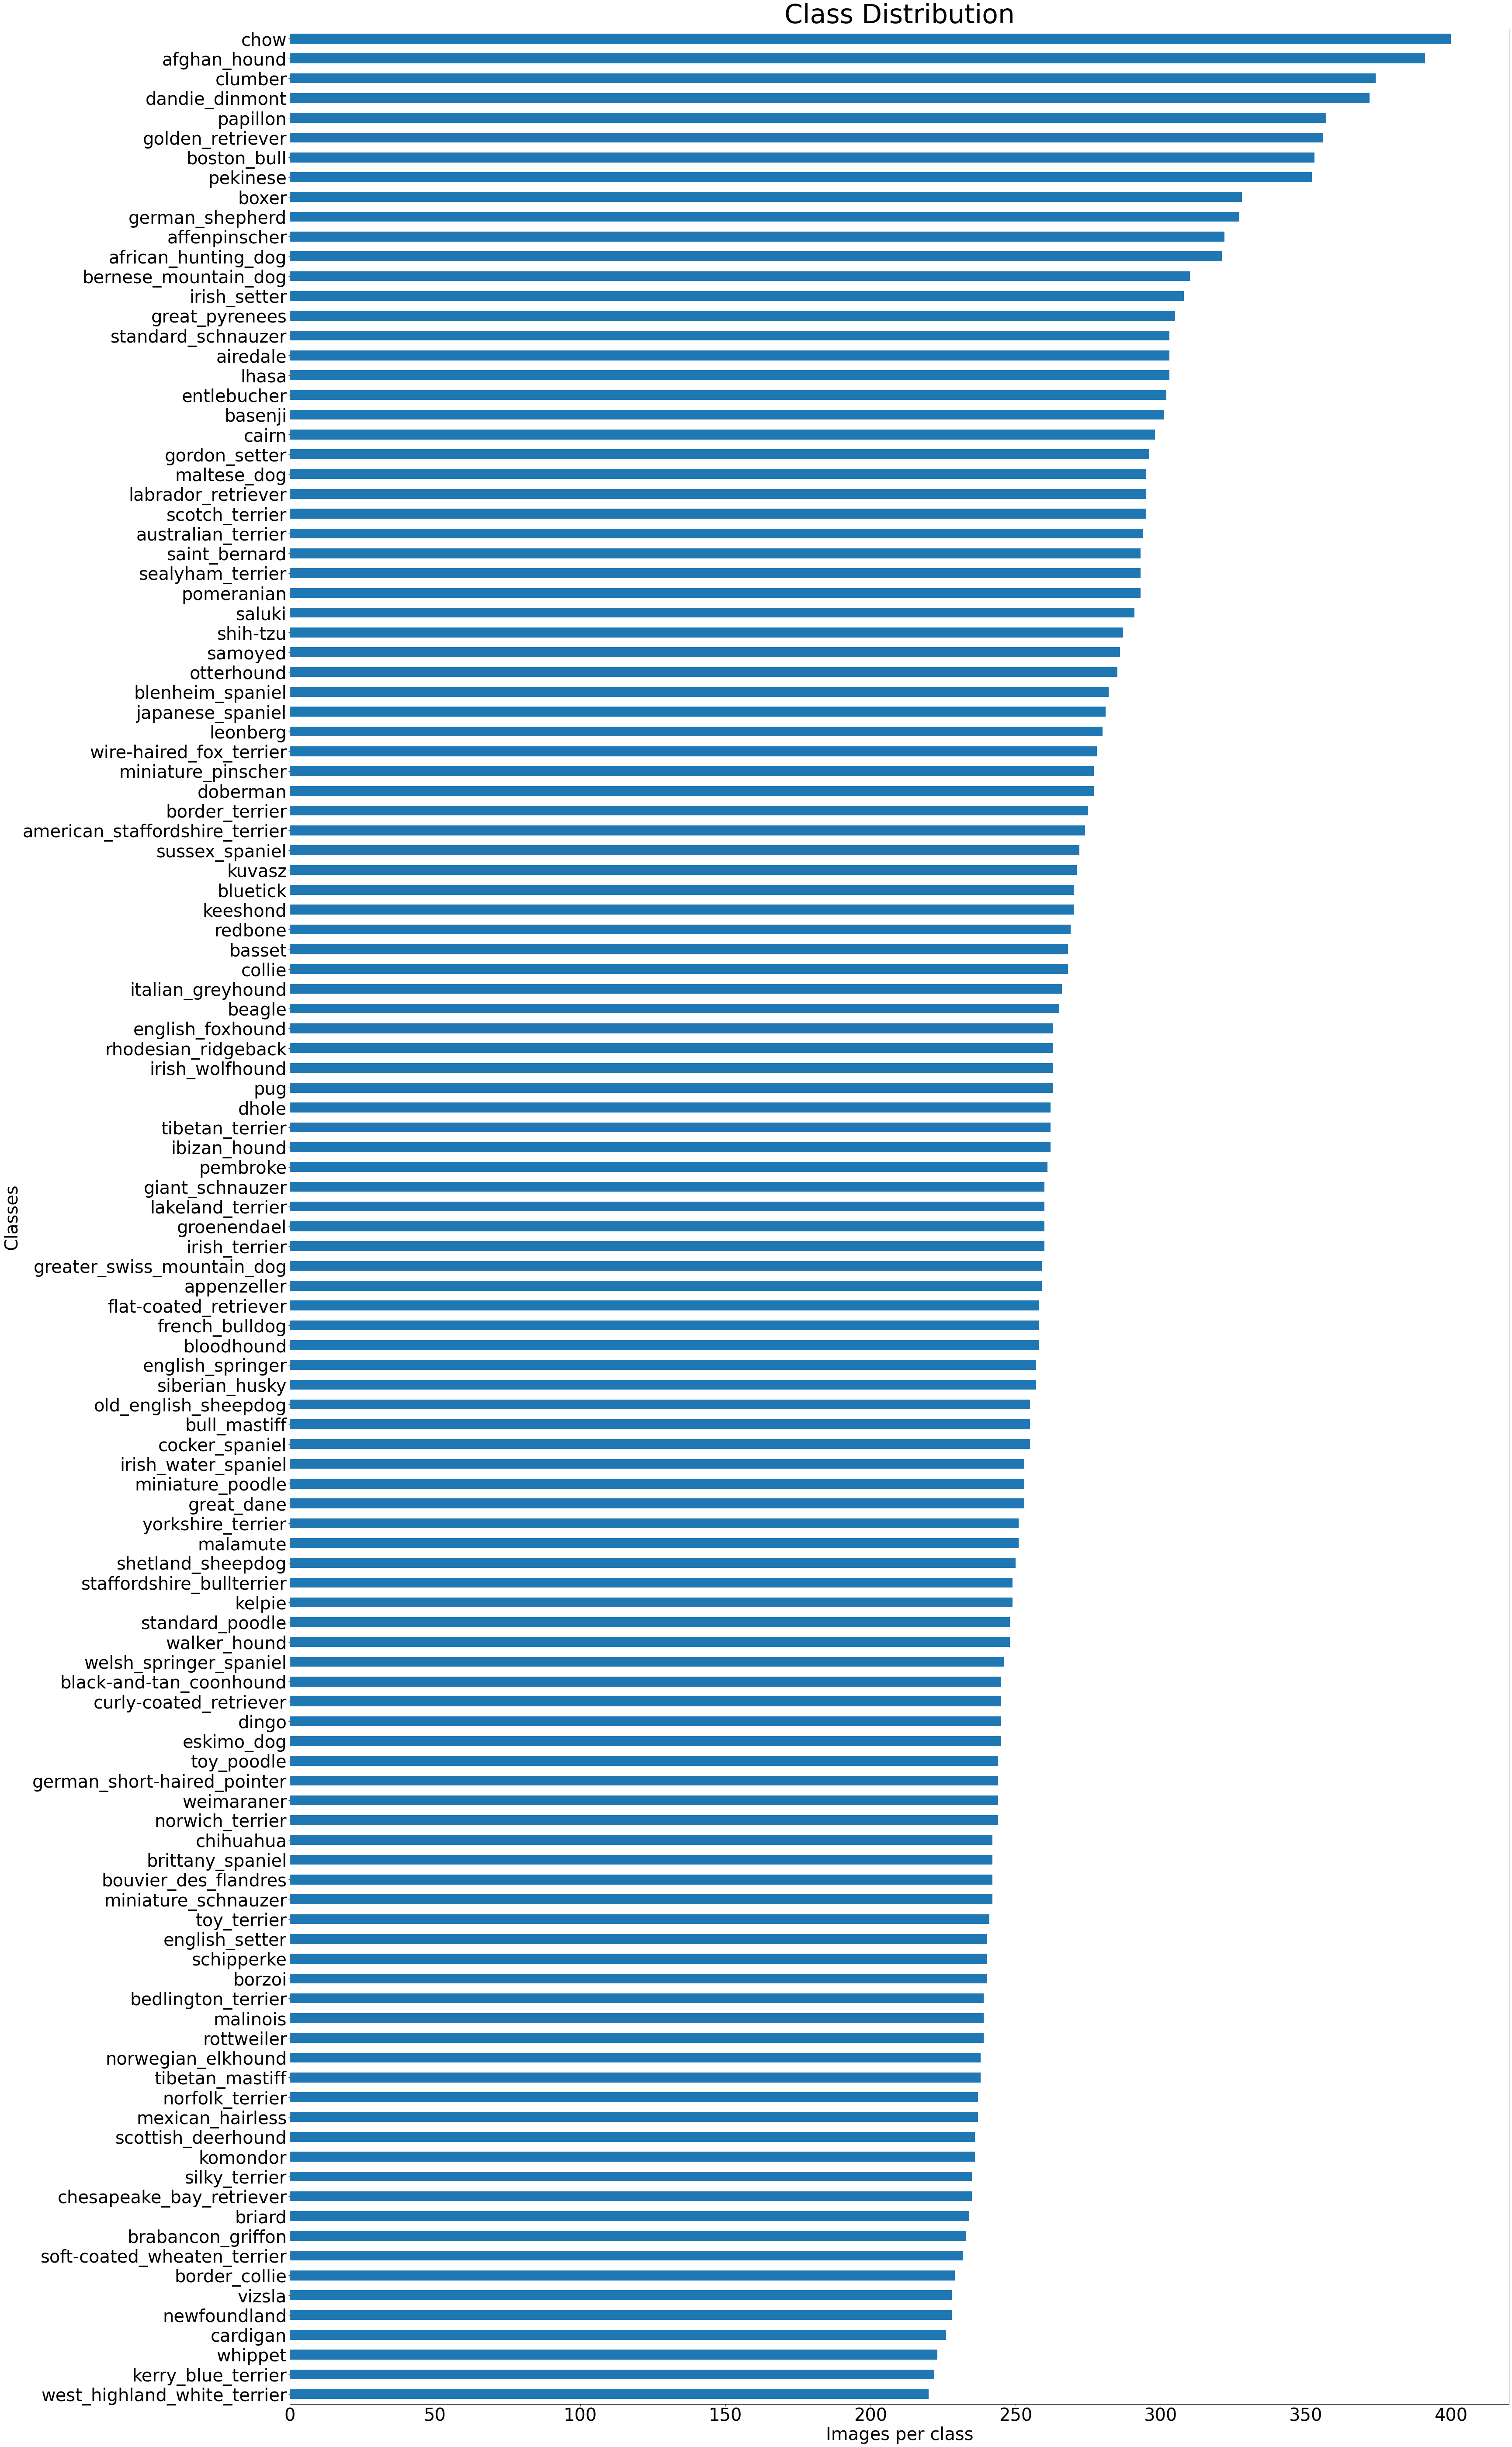

In [4]:
# Take a look at the class/breed distribution
ax=pd.value_counts(train_dogs['label'],ascending=True).plot(kind='barh',
                                                       fontsize="40",
                                                       title="Class Distribution",
                                                       figsize=(50,100))
ax.set(xlabel="Images per class", ylabel="Classes")
ax.xaxis.label.set_size(40)
ax.yaxis.label.set_size(40)
ax.title.set_size(60)
plt.show()

In [5]:
target_labels = train_dogs['label']

In [6]:
# One hot code the labels - need this for the model
one_hot = pd.get_dummies(target_labels, sparse = True)
one_hot_labels = np.asarray(one_hot)

In [7]:
train_data = np.array([img_to_array(load_img(img, target_size=(200, 200))) for img in train_dogs['path'].values.tolist()]).astype('float32')

In [8]:
x_train, x_validation, y_train, y_validation = train_test_split(train_data, target_labels, test_size=0.2, stratify=np.array(target_labels), random_state=100)

In [9]:
print ('x_train shape = ', x_train.shape)
print ('x_validation shape = ', x_validation.shape)

x_train shape =  (25889, 200, 200, 3)
x_validation shape =  (6473, 200, 200, 3)


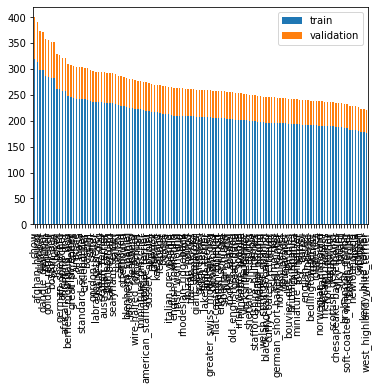

In [10]:
data = y_train.value_counts().sort_index().to_frame()   # this creates the data frame with train numbers
data.columns = ['train']   # give the column a name
data['validation'] = y_validation.value_counts().sort_index().to_frame()   # add the validation numbers
new_plot = data[['train','validation']].sort_values(['train']+['validation'], ascending=False)   # sort the data
new_plot.plot(kind='bar', stacked=True)
plt.show()

In [11]:
y_train = pd.get_dummies(y_train.reset_index(drop=True)).values
y_validation = pd.get_dummies(y_validation.reset_index(drop=True)).values

In [12]:
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=30, 
                                   # zoom_range = 0.3, 
                                   width_shift_range=0.2,
                                   height_shift_range=0.2, 
                                   horizontal_flip = 'true')
train_generator = train_datagen.flow(x_train, y_train, shuffle=False, batch_size=10, seed=10)

In [13]:
val_datagen = ImageDataGenerator(rescale = 1./255)
val_generator = train_datagen.flow(x_validation, y_validation, shuffle=False, batch_size=10, seed=10)

In [14]:
base_model = InceptionV3(weights = 'imagenet', include_top = False, input_shape=(200, 200, 3))

In [15]:
x = base_model.output
x = GlobalAveragePooling2D()(x)

In [16]:
x = Dense(512, activation='relu')(x)
predictions = Dense(120, activation='softmax')(x)

In [17]:
model = Model(inputs = base_model.input, outputs = predictions)

In [18]:
for layer in base_model.layers:
    layer.trainable = False

In [19]:
model.compile(Adam(lr=.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [20]:
#weights
#all_labels = [lbs for lbs in train_dogs['label']]# for label in lbs]
#labels_count = Counter(all_labels)
#total_counts = sum(labels_count.values())
#class_weights = {train_generator.class_indices[cls]: total_counts / count for cls, count in labels_count.items()}
#class_weights

In [21]:
trial = 1
epochs = 160
metrics = Metrics(val_generator, validation_steps=10)
history = model.fit_generator(
    generator = train_generator,
    steps_per_epoch = len(train_generator) // 10,
    validation_data = val_generator,
    validation_steps = len(val_generator) // 10,
    epochs = epochs,
#    class_weight = class_weights,
    callbacks = [metrics],
)
model.save_weights(datetime.today().strftime("%Y%m%d")+ '_weights_' +str(epochs) + '_' + str(trial) +'.h5')
model.save(datetime.today().strftime("%Y%m%d")+ '_model_'+ str(epochs) + '_' + str(trial) +'.h5')

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/160
258/258 [==============================] - ETA: 0s - loss: 3.6768 - accuracy: 0.2451 ETA: 1s - loss: 3WARNING:tensorflow:From <ipython-input-2-c6d84e656c29>:15: Model.predict_generator (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
Please use Model.predict, which supports generators.
 - val_f1_score: 0.20962 - val_precision: 0.29500 - val_recall: 0.18000
258/258 [==============================] - 39s 153ms/step - loss: 3.6768 - accuracy: 0.2451 - val_loss: 2.3864 - val_accuracy: 0.4516
Epoch 2/160
258/258 [==============================] - 32s 124ms/step - loss: 1.9532 - accuracy: 0.5202 - val_loss: 1.7826 - val_accuracy: 0.5125
Epoch 3/160
258/258 [==============================] - 35s 135ms/step - loss: 1.6398 - accuracy: 0.5705 - val_loss: 1.5953 - val_accuracy: 0.5688
Epoch 4/160
258/258 [==========================

Text(0.5, 0, 'Epoch')

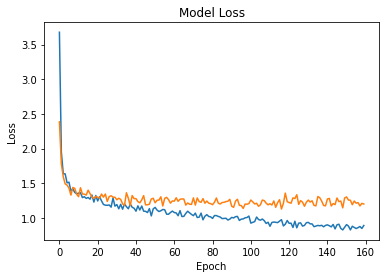

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

Text(0.5, 0, 'Epoch')

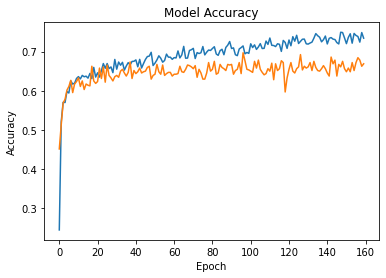

In [23]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

In [24]:
predictions = model.predict(val_generator)
#predictions_class = model.predict_classes(validation_generator)

In [25]:
(model.predict(val_generator) > 0.5).astype("int32")

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [26]:
predictions

array([[9.92979467e-01, 1.88206786e-06, 3.17698527e-06, ...,
        4.70902620e-07, 4.58107763e-07, 1.04750172e-04],
       [1.98052619e-02, 8.96953978e-04, 4.06939362e-05, ...,
        6.36801487e-05, 3.03125107e-05, 1.36658335e-02],
       [1.50168287e-08, 1.45287174e-07, 2.93867108e-09, ...,
        1.02353067e-06, 7.03038222e-06, 2.47256878e-07],
       ...,
       [3.15785510e-05, 3.77241207e-08, 2.29207913e-07, ...,
        1.42980698e-05, 7.87949688e-08, 1.13875531e-08],
       [2.18090081e-05, 7.56187410e-06, 8.39313652e-05, ...,
        1.64539131e-06, 1.34008781e-06, 3.31914307e-05],
       [7.61704921e-09, 1.80863591e-08, 1.07830679e-07, ...,
        2.07770597e-07, 3.17157661e-10, 2.04487746e-11]], dtype=float32)

In [27]:
test_loss, test_acc = model.evaluate(val_generator, batch_size=50, verbose=1)

648/648 [==============================] - 39s 60ms/step - loss: 1.3479 - accuracy: 0.6442


In [28]:
scores = model.evaluate_generator(val_generator, steps=5)

Instructions for updating:
Please use Model.evaluate, which supports generators.


In [29]:
print("-- Evaluate --")
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))

-- Evaluate --
accuracy: 66.00%
